<a href="https://colab.research.google.com/github/tontan2545/Emotion-Recognition/blob/main/emotion_recognition_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nonthapatkaewamporn","key":"13da06eacc309d0e25a7f502cd53814b"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!mkdir train
!unzip train.csv.zip -d train
!mkdir test
!unzip test.csv.zip -d test
!mkdir icml_face_data
!unzip icml_face_data.csv.zip -d icml_face_data

!mkdir train/images
!mkdir train/images/Angry
!mkdir train/images/Disgust
!mkdir train/images/Fear
!mkdir train/images/Happy
!mkdir train/images/Sad
!mkdir train/images/Surprise
!mkdir train/images/Neutral

!mkdir test/images
!mkdir test/images/Angry
!mkdir test/images/Disgust
!mkdir test/images/Fear
!mkdir test/images/Happy
!mkdir test/images/Sad
!mkdir test/images/Surprise
!mkdir test/images/Neutral

 94% 86.0M/92.0M [00:00<00:00, 107MB/s] 
100% 92.0M/92.0M [00:00<00:00, 134MB/s]
 79% 61.0M/77.3M [00:00<00:00, 88.8MB/s]
100% 77.3M/77.3M [00:00<00:00, 126MB/s] 
 88% 17.0M/19.3M [00:00<00:00, 46.0MB/s]
100% 19.3M/19.3M [00:00<00:00, 48.8MB/s]
 84% 81.0M/96.6M [00:00<00:00, 101MB/s] 
100% 96.6M/96.6M [00:00<00:00, 134MB/s]
  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 7.43MB/s]
Archive:  train.csv.zip
  inflating: train/train.csv         
Archive:  test.csv.zip
  inflating: test/test.csv           
Archive:  icml_face_data.csv.zip
  inflating: icml_face_data/icml_face_data.csv  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns 
from keras.preprocessing.image import ImageDataGenerator as Imgen
from tensorflow.keras.utils import to_categorical

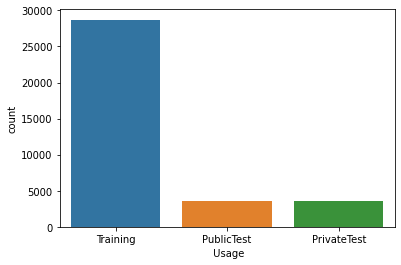

In [ ]:
dat = pd.read_csv('./icml_face_data/icml_face_data.csv')
dat.head()
sns.countplot(x = " Usage", data=dat, )

In [ ]:
usages = dat[" Usage"].unique()
print(usages)

['Training' 'PublicTest' 'PrivateTest']


In [ ]:
def convert_to_image(string_data):
  image_numpy = []
  for n in string_data:
    image_numpy.append(np.reshape(np.array(n.split()).astype(np.int), (48,48)))
  return np.array(image_numpy)

In [ ]:
vdat = dat[dat[" Usage"] == "PublicTest"]
val_data = convert_to_image(vdat[" pixels"].to_numpy())
val_label = vdat["emotion"].to_numpy()


In [ ]:
print(val_data[0].shape)
print(val_data[0])
print(val_label)

(48, 48)
[[254 254 254 ...  16   0 161]
 [254 254 254 ...  17   0 122]
 [254 254 254 ...  26   0 114]
 ...
 [ 66  86  99 ... 255 252 254]
 [ 84  92  92 ... 236 255 255]
 [ 93  90  85 ...  42 129 180]]
[0 1 4 ... 4 4 4]


In [ ]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [ ]:
tdat = dat[dat[" Usage"]=="Training"]
train_data = convert_to_image(tdat[" pixels"].to_numpy())
train_label = tdat["emotion"].to_numpy()

In [ ]:
count = len(tdat['emotion'])
for i in range(7):
  print()
for i in range(7):
  print(round(len(tdat[tdat['emotion'] == i]) / count * 100,2), end="")
  if i != 6:
    print(end=" : ")  








13.92 : 1.52 : 14.27 : 25.13 : 16.82 : 11.05 : 17.29

In [ ]:
tstdat = dat[dat[" Usage"]== "PrivateTest"]
test_data = convert_to_image(tstdat[" pixels"].to_numpy())
test_label = tstdat["emotion"].to_numpy()

In [ ]:
count = len(tstdat['emotion'])
for i in range(7):
  print(round(len(tstdat[tstdat['emotion'] == i]) / count * 100,2), end="")
  if i != 6:
    print(end=" : ")  

13.68 : 1.53 : 14.71 : 24.49 : 16.55 : 11.59 : 17.44

In [ ]:
from PIL import Image


In [ ]:
def save_to_Image(dir_name,data,label):
  for i in range(len(data)):
    Image.fromarray(data[i].astype(np.uint8)).save(dir_name + str(emotions[label[i]]) + '/' + str(i)+'.jpg')

In [ ]:
save_to_Image("./train/images/", train_data, train_label)

In [ ]:
save_to_Image("./test/images/", test_data, test_label)

In [ ]:
img_size = 128
batch = 32


data_gen = Imgen(rescale=1./255, rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
data_gen_val = Imgen(rescale=1./255, rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

train_gen = data_gen.flow_from_directory('./train/images/', target_size=(img_size,img_size), batch_size=batch, class_mode='categorical', shuffle=True)

val_gen = data_gen_val.flow_from_directory('./test/images/', target_size=(img_size,img_size), batch_size=batch, class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [ ]:
base_model = keras.applications.MobileNetV2(include_top=False, input_shape=(img_size,img_size,3), weights="imagenet")
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
________________

In [ ]:
base_model.trainable = False

#Adding custom head

In [ ]:
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(7, activation="softmax")(x)

In [ ]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_gen, epochs=25, validation_data= val_gen )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
898/898 [==============================] - 179s 168ms/step - loss: 1.8696 - accuracy: 0.2613 - val_loss: 1.7397 - val_accuracy: 0.3123
Epoch 2/25
898/898 [==============================] - 149s 166ms/step - loss: 1.6911 - accuracy: 0.3350 - val_loss: 1.6505 - val_accuracy: 0.3592
Epoch 3/25
898/898 [==============================] - 153s 170ms/step - loss: 1.6351 - accuracy: 0.3613 - val_loss: 1.6239 - val_accuracy: 0.3555
Epoch 4/25
898/898 [==============================] - 149s 166ms/step - loss: 1.6097 - accuracy: 0.3722 - val_loss: 1.5854 - val_accuracy: 0.3761
Epoch 5/25
898/898 [==============================] - 150s 167ms/step - loss: 1.5909 - accuracy: 0.3820 - val_loss: 1.5807 - val_accuracy: 0.3748
Epoch 6/25
898/898 [==============================] - 150s 167ms/step - loss: 1.5790 - accuracy: 0.3927 - val_loss: 1.5613 - val_accuracy: 0.3912
Epoch 7/25
898/898 [==============================] - 148s 165ms/step - loss: 1.5679 - accuracy: 0.3943 - val_loss: 1.5619 -

#Fine Tuning

In [ ]:
print(len(base_model.layers))

154


In [ ]:
base_model.trainable=True

In [ ]:
for layer in base_model.layers[:100]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_gen, epochs=25, validation_data= val_gen )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
898/898 [==============================] - 166s 178ms/step - loss: 1.5483 - accuracy: 0.4327 - val_loss: 1.9550 - val_accuracy: 0.4330
Epoch 2/25
898/898 [==============================] - 158s 176ms/step - loss: 1.2800 - accuracy: 0.5131 - val_loss: 1.6354 - val_accuracy: 0.4898
Epoch 3/25
898/898 [==============================] - 157s 175ms/step - loss: 1.2055 - accuracy: 0.5433 - val_loss: 1.3699 - val_accuracy: 0.5322
Epoch 4/25
898/898 [==============================] - 158s 175ms/step - loss: 1.1577 - accuracy: 0.5617 - val_loss: 1.3516 - val_accuracy: 0.5378
Epoch 5/25
898/898 [==============================] - 159s 177ms/step - loss: 1.1164 - accuracy: 0.5731 - val_loss: 1.3000 - val_accuracy: 0.5550
Epoch 6/25
898/898 [==============================] - 158s 176ms/step - loss: 1.0863 - accuracy: 0.5891 - val_loss: 1.3148 - val_accuracy: 0.5639
Epoch 7/25
898/898 [==============================] - 157s 175ms/step - loss: 1.0546 - accuracy: 0.6042 - val_loss: 1.2427 -